### Imports

In [1]:
import pandas as pd
import json
import zipfile
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from networkx.algorithms.community import louvain_communities

from tqdm import tqdm
import os
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler


### ChatGPT list

For the baseline of the project I had to collect data and I started with asking ChatGPT to generate lists or dicts of antisimitic keywords

In [2]:
antisemitic_references = [
    # Common Antisemitic Slurs
    "((()))", "Kike", "Heeb", "Yid", "Shlomo", "Shekelstein", "Goyim",
    "Ashke-nazi", "Jewess", "Goldstein", "Schlomo", "JIDF", "Golem",
    "Bagel boy", "Chaim", "Judenschwein", "Matzoh muncher", "Shylock",
    "Christ killer", "Jewrat", "Zhid", "Mossad agent", "Judenfrei",
    "Jew York", "Crypto-Jew", "Merchant", "Cohencidence",

    # Codes and Numbers Used in Hate Speech
    "109", "110", "1488", "88", "14 words", "14/88", "13% 50%", "12 Tribes",
    "GDL", "Dresden 45", "Day of the Rope", "Weimerica", "Hail victory",

    # Holocaust Denial and Distortion
    "Holohoax", "Six Gorillion", "Hollow cost", "Soap and lampshades",
    "Did six million really die?", "Anne Frank fiction", "Holo-myth",
    "David Irving was right", "Shoah business", "Holocaustianity",
    "Auschwitz swimming pool", "Happy Holocaust", "Faurisson was right",
    "Holocaust revisionism", "Gas chamber hoax", "Six million lies",

    # Conspiracy Theories about Jewish Control
    "ZOG", "Zionist Occupied Government", "Jew world order", "Israel lobby",
    "Rothschilds", "George Soros", "International finance", "Big Jew",
    "Talmudic globalists", "The Chosen", "Neo-Cohen", "Wall Street Jews",
    "Dancing Israelis", "Protocols of Zion", "Mossad false flag",
    "Space lasers", "Weather control", "Noahide laws", "Jewish Bolshevism",
    "Jewish slave trade", "Chabad mafia", "Blood libel", "Jewish privilege",
    "Zionist deep state", "Jewish science hoax", "Jews control cryptocurrency",
    "Jews spreading degeneracy", "Jewish porn industry", "Jewish banking cartel",
    "Jews and organ harvesting", "Rothschild weather control",
    "All wars are banker wars", "Mossad blackmail ops", "Zionist plandemic",

    # Dog Whistles and Coded Language
    "Cultural Marxism", "Hollywood elite", "Deep state", "Jew-run government",
    "Dual loyalty", "Cabal", "Usury", "Kosher banking", "Globalist",
    "Neo-Weimar degeneracy", "Open borders for thee, not for me",
    "They cry out in pain as they strike you", "Fellow white people",
    "Jews ruin everything", "Goyim revolution", "Judah infiltrators",
    "Rabbis run the world", "Jewish hive mind", "Kosher nostra",

    # Misrepresentation of Jewish Faith and Practices
    "Jewish ritual murder", "Talmud pedophilia", "Moloch worshippers",
    "Jewish human sacrifice", "Talmudic deceit", "Eternal Jew",
    "Jewish supremacist", "Tikkun Olam conspiracy", "Shabbos goy",
    "Kosher tax", "Noahide laws genocide", "Judenzählung",

    # Historical Antisemitic Accusations
    "Jews killed Christ", "Jews betrayed Rome", "King Edward I was right",
    "Expulsion of Jews 109 times", "Holodomor cover-up", "Weimar decadence",
    "Hannukah hoax", "Dreyfus was guilty", "Jews behind communism",
    "Jews and the Black Plague", "Jews and the Spanish Flu",

    # Phrases Targeting Jewish Identity
    "You will never be white", "Goyim cattle", "Oy vey, the goyim know",
    "Jews gonna Jew", "A merchant is always up to something",
    "Every. Single. Time.", "Jewing it up", "Jews and their lies",
    "Gas the Jews", "Exterminate the root", "It’s the Jews",
    "Anne Frank’s secret diary",

    # Social Media Hashtags and Variants
    "#BanTheADL", "#OpenBordersForIsrael", "#EndZOG", "#WhiteGenocide",
    "#KikeFree", "#NoMoreWarsForIsrael", "#JewishSupremacy", "#GoyimRevolt",
    "#HappyMerchant", "#DeJudeify", "#SynagogueOfSatan", "#IsraelDid911",
    "#SorosFundsAntifa", "#BanKosher", "#MossadFalseFlags", "#StopTheZionists",
    "#JewishPuppet", "#ZionistTakeover", "#JewishQuestion", "#EndJewry",
    "#HolocaustMyth", "#IsraelApartheid", "#JewsDidIt", "#JewishPropaganda",

    # Far-Right and Neo-Nazi Terminology
    "Fourth Reich", "Blood and soil", "Europa the last battle",
    "White genocide", "Diversity is code for white genocide",
    "Final solution", "Pure blood", "Aryan supremacy", "White ethnostate",
    "Race war now", "Zionist puppets", "Merchant memes", "GDL tactics",

    # Antisemitic References in Memes
    "Happy Merchant", "Goyslop", "Schlomo Shekelstein", "Anne Frank's drum set",
    "Jewish space laser", "Oy gevalt", "We wuz goyim", "Shoah business",
    "Talmudic overlords", "Zionist conspiracy", "Jewish IQ hoax",
    "The Nose Knows", "Bagel IQ", "Jewish overrepresentation in media",

    # Derogatory Terms for Jewish Communities
    "Hasbara troll", "Golem servant", "Marranos", "Crypto-Jew",
    "JIDF shill", "Jew-run", "Jewish gangsters", "Jew York crime family",

    # Fake Jewish Historical Conspiracies
    "Jews sold slaves", "Jews betrayed Germany", "Jews caused WW1",
    "Jews responsible for 1929 crash", "Jews caused Bolshevism",
    "Jewish Bolsheviks killed millions", "Jews orchestrated Pearl Harbor",
    "Jews started Vietnam", "Jewish bankers created communism",
    "Jews behind 2008 crash", "Jews created woke culture",
    "Jews fund leftist movements", "Jews control tech industry",

    # Fringe Extremist Theories
    "Zionist aliens", "Jews and reptilians", "Jews own the Vatican",
    "Chabad infiltration of governments", "Jewish world depopulation",
    "Jews hoard advanced technology", "Jewish intergalactic bankers",
    "Jewish Druid elite", "Jewish mind control", "Jewish time travel"
]
antisemitic_references = [i.lower() for i in antisemitic_references]

### IsHamRed

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/My Drive/AntiP/anti/"
submission = "submissions.zip"
comments = "comments.zip"
conversation = "conversations.zip"
df_sub = pd.read_csv(data_path + "full_submission_ids.csv")
df_comm = pd.read_csv(data_path + "full_comments_ids.csv")

In [ ]:
#### dont run it!
# zips = [submission, comments, conversation]
# for i, zip in tqdm(enumerate(zips)):
#   with zipfile.ZipFile(data_path + zip, 'r') as zip_ref:
#     zip_ref.extractall(data_path + zip[:-4])
# print('Open all IsHamRed')


3it [06:12, 124.19s/it]

Open all IsHamRed


#### Process data

In [5]:
def load_json_from_directory(directory_path):
    """
    Loads all JSON files from a given directory into a list.

    :param directory_path: Path to the directory containing JSON files.
    :return: List of dictionaries containing JSON file contents.
    """
    json_data_list = []

    if not os.path.isdir(directory_path):
        print(f"Error: Directory '{directory_path}' does not exist.")
        return []

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):  # Ensure it's a JSON file
            file_path = os.path.join(directory_path, filename)
            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    print(f'Upload {file_path}')
                    json_data = json.load(file)
                    json_data_list.append(json_data)
                    break

            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON in file {filename}")


    print(f"Loaded {len(json_data_list)} JSON files from {directory_path}")
    return json_data_list

# Define paths
data_path = "/content/drive/My Drive/AntiP/anti/"
# comments_path = data_path + 'comments/comments/'
# submissions_path = data_path + 'submissions/submissions/'
conversations_path = data_path + 'conversations/conversations/'

# Load data from all three directories
all_json_data = []
for path in [conversations_path]:
    all_json_data.extend(load_json_from_directory(path))

print(f"Total JSON files loaded: {len(all_json_data)}")


Upload /content/drive/My Drive/AntiP/anti/conversations/conversations/2023_10.json
Loaded 1 JSON files from /content/drive/My Drive/AntiP/anti/conversations/conversations/
Total JSON files loaded: 1


In [7]:
# import pickle
# # Get the size using pickle serialization
# json_size_bytes = len(pickle.dumps(all_json_data))

# # Convert to megabytes
# json_size_mb = json_size_bytes / (1024 * 1024)

# print(f"Total JSON files loaded: {len(all_json_data)}")
# print(f"Total size of JSON data: {json_size_mb:.2f} MB")

Total JSON files loaded: 4
Total size of JSON data: 121255.62 MB


In [ ]:
len(all_json_data[0])

180420

In [ ]:
all_json_data[0][-3]['comments_df']

[{'subreddit': 'Jewish',
  'id': 'k7auop8',
  'text': 'thank you for your submission. during this time, all posts need to be manually reviewed and approved by a moderator before they appear for all users. since human mods are not online 24/7, approval could take anywhere from a few minutes to a few hours. thank you for your patience during this difficult and sensitive time.*i am a bot, and this action was performed automatically. please [contact the moderators of this subreddit](/message/compose/?to=/r/jewish) if you have any questions or concerns.*',
  'author': 'BvupNpefsbups',
  'datetime': '2023-10-31',
  'timestamp': '1698796733.0',
  'submission_id': '17kz5xb',
  'parent_id': '17kz5xb',
  'controversial': 0,
  'score': 1,
  'ups': 1,
  'downs': 0}]

In [8]:
import pandas as pd

# Example JSON data
data = all_json_data[0][:100_000]

# Extracting post data
post_df = pd.DataFrame([
    {
        'subreddit': item['subreddit'],
        'id': item['id'],
        'author': item['author'],
        'datetime': item['datetime'],
        'timestamp': item['timestamp'],
        'title': item['title'],
        'text': item['text'],
        'score': item['score'],
        'upvote_ratio': item['upvote_ratio'],
        'upvotes': item['upvotes'],
        'num_comments': item['num_comments'],
        'freepalestine_islamophobia': item['freepalestine_islamophobia'],
        'zionism_antisemitism': item['zionism_antisemitism']
    } for item in data
])

# Extracting comment data
comment_data = []
for item in data:
    for comment in item['comment_df']:
        comment_data.append({
            'subreddit': item['subreddit'],
            'id': comment.get('id', ''),
            'text': comment.get('text', ''),
            'author': comment.get('author', ''),
            'datetime': comment.get('datetime', ''),
            'timestamp': comment.get('timestamp', ''),
            'submission_id': item['id'],
            'parent_id': comment.get('parent_id', ''),
            'controversial': comment.get('controversial', False),
            'score': comment.get('score', 0),
            'ups': comment.get('ups', 0),
            'downs': comment.get('downs', 0)
        })

comment_df = pd.DataFrame(comment_data)




In [9]:
def todatetime(post_df, comment_df):
    post_df['datetime'] = pd.to_datetime(post_df['datetime'])
    comment_df['datetime'] = pd.to_datetime(comment_df['datetime'])
    post_df['date'] = post_df['datetime'].dt.date
    comment_df['date'] = comment_df['datetime'].dt.date


In [10]:
def compute_bow_tfidf(post_df, comment_df, antisemitic_references):
    # Prepare combined text
    post_df['combined_text'] = post_df['title'].fillna('') + ' ' + post_df['text'].fillna('')
    comment_df['combined_text'] = comment_df['text'].fillna('')

    all_texts = pd.concat([post_df[['id', 'combined_text', 'date']], comment_df[['id', 'combined_text', 'date']]]).dropna()
    antisemitic_references = list(set(antisemitic_references))
    bow_vectorizer = CountVectorizer(vocabulary=antisemitic_references, lowercase=True)
    tfidf_vectorizer = TfidfVectorizer(vocabulary=antisemitic_references, lowercase=True)

    bow_matrix = bow_vectorizer.fit_transform(all_texts['combined_text'])
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts['combined_text'])

    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    bow_df['id'] = all_texts['id'].values
    tfidf_df['id'] = all_texts['id'].values
    bow_df['date'] = all_texts['date'].values
    tfidf_df['date'] = all_texts['date'].values
    return bow_df, tfidf_df

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

def classify_with_llms(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = [
        'cardiffnlp/twitter-roberta-base-hate',
        'Hate-speech-CNERG/dehatebert-mono-english'
    ]

    results = {model: [] for model in models}

    for model_name in models:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
        model.eval()  # Set model to evaluation mode

        def predict(text):
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU

            with torch.no_grad(), torch.cuda.amp.autocast():  # Enable mixed precision for speed
                outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)[0][1].item()
            return probs

        for text in tqdm(texts, desc=f'Processing {model_name}'):
            results[model_name].append(predict(text))

    return results


In [13]:
todatetime(post_df, comment_df)
daily_bow_score, daily_tfidf_score = compute_bow_tfidf(post_df, comment_df, antisemitic_references)

In [27]:
daily_bow_score.to_csv('bow.csv', index=False)
daily_tfidf_score.to_csv('tf.csv', index=False)

In [15]:
llm_results_post = classify_with_llms(post_df['combined_text'].tolist())
# llm_results_comment = classify_with_llms(comment_df['combined_text'].tolist())

for model_name, scores in llm_results_post.items():
    post_df[model_name] = scores
# for model_name, scores in llm_results_comment.items():
#     comment_df[model_name] = scores

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Processing cardiffnlp/twitter-roberta-base-hate:   0%|          | 0/100000 [00:00<?, ?it/s]<ipython-input-12-f46f55d35805>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():  # Enable mixed precision for speed


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Processing cardiffnlp/twitter-roberta-base-hate: 100%|██████████| 100000/100000 [23:07<00:00, 72.06it/s]


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Processing Hate-speech-CNERG/dehatebert-mono-english:   0%|          | 17/100000 [00:00<20:46, 80.18it/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Processing Hate-speech-CNERG/dehatebert-mono-english: 100%|██████████| 100000/100000 [20:33<00:00, 81.10it/s]


In [28]:
post_df.to_csv('post.csv', index=False)
# comment_df.to_csv('comment_df.csv', index=False)

In [19]:
# Normalize scores and sum BoW * TF-IDF per day
def normalize_and_aggregate_scores(post_df, comment_df, bow_df, tfidf_df):
    for model_name in ['cardiffnlp/twitter-roberta-base-hate', 'Hate-speech-CNERG/dehatebert-mono-english']:
        post_df[f'{model_name}_normalized'] = (post_df[model_name] - post_df[model_name].min()) / (post_df[model_name].max() - post_df[model_name].min())
        # comment_df[f'{model_name}_normalized'] = (comment_df[model_name] - comment_df[model_name].min()) / (comment_df[model_name].max() - comment_df[model_name].min())

    bow_df['bow_tfidf_sum'] = bow_df.iloc[:, :-2].sum(axis=1) * tfidf_df.iloc[:, :-2].sum(axis=1)
    daily_scores = bow_df.groupby('date')['bow_tfidf_sum'].sum().reset_index()

    return daily_scores

In [20]:
daily_scores = normalize_and_aggregate_scores(post_df, comment_df, daily_bow_score, daily_tfidf_score)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
daily_scores

In [23]:
# Track antisemitic trend analysis using N-Grams
def track_antisemitic_trends(post_df):
    post_df['combined_text'] = post_df['title'].fillna('') + " " + post_df['text'].fillna('')
    # comment_df['combined_text'] = comment_df['text'].fillna('')
    all_texts = post_df[['date', 'combined_text']]

    vectorizer = CountVectorizer(ngram_range=(10,15), stop_words='english', max_features=50)
    ngram_matrix = vectorizer.fit_transform(all_texts['combined_text'])

    ngram_df = pd.DataFrame(ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    ngram_df['date'] = all_texts['date'].values

    daily_ngram_trends = ngram_df.groupby('date').sum().reset_index()

    top_ngrams = daily_ngram_trends.iloc[:, 1:].sum().sort_values(ascending=False).head(10).index
    daily_ngram_trends.set_index('date')[top_ngrams].plot(figsize=(12,6), linewidth=2)
    plt.title("Top Antisemitic N-Grams Over Time")
    plt.xlabel("Date")
    plt.ylabel("Frequency")
    plt.legend(title="N-Grams", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid()

    plt.show()


In [26]:
set(post_df['subreddit'])

{'2ndYomKippurWar',
 'ALJAZEERAauto',
 'AntiSemitismInReddit',
 'AskMiddleEast',
 'AskReddit',
 'AutoNewspaper',
 'BBCauto',
 'BreakingNews24hr',
 'Britain',
 'CNNauto',
 'CombatFootage',
 'Conservative',
 'Destiny',
 'DisneyNewsfeed',
 'EndlessWar',
 'Ernesto_it',
 'FOXauto',
 'FRANCE24auto',
 'FreeKarma4You',
 'GUARDIANauto',
 'Gaza',
 'Hasan_Piker',
 'Israel',
 'IsraelCrimes',
 'IsraelHamasWar',
 'IsraelICYMI',
 'IsraelPalestine',
 'IsraelUnderAttack',
 'IsraelVsHamas',
 'IsraelWar',
 'IsraelWarVideoReport',
 'Israel_Palestine',
 'IsrealPalestineWar_23',
 'ItaliaBox',
 'JavaScriptJob',
 'Jewish',
 'Judaism',
 'LabourUK',
 'Mexico_Videos',
 'Muslim',
 'MuslimCorner',
 'MuslimLounge',
 'NBCauto',
 'NYTauto',
 'N_N_N',
 'NewIran',
 'NewsOfTheStupid',
 'NewsWhatever',
 'NoFilterNews',
 'NoStupidQuestions',
 'NonCredibleDefense',
 'Palestine',
 'Palestinian_Violence',
 'PublicFreakout',
 'ReactJSJobs',
 'SeenOnNews_longtail',
 'TIMESINDIAauto',
 'TWTauto',
 'TheDeprogram',
 'TheMajorityR

## Graph

In [ ]:

# Build Reddit interaction graph and detect communities per day
def build_user_graph_and_communities(post_df, comment_df):
    unique_dates = sorted(post_df['date'].unique())
    daily_graphs = {}

    for date in unique_dates:
        G = nx.DiGraph()
        daily_posts = post_df[post_df['date'] == date]
        daily_comments = comment_df[comment_df['date'] == date]

        # Add edges based on comment interactions (user -> parent user)
        for _, row in daily_comments.iterrows():
            if pd.notna(row['author']) and pd.notna(row['parent_id']):
                parent_id = row['parent_id']
                if parent_id in daily_posts['id'].values:
                    parent_author = daily_posts.loc[daily_posts['id'] == parent_id, 'author'].values[0]
                    if pd.notna(parent_author) and parent_author != row['author']:
                        G.add_edge(row['author'], parent_author)

        # Compute centrality metrics
        betweenness = nx.betweenness_centrality(G)  # Influence in communication
        eigenvector = nx.eigenvector_centrality(G, max_iter=500)  # Importance based on connections
        pagerank = nx.pagerank(G)  # Google-style importance scoring
        closeness = nx.closeness_centrality(G)  # Measures how close a node is to all others

        # Convert centrality results into a DataFrame
        centrality_df = pd.DataFrame({
            'user': list(betweenness.keys()),
            'betweenness_centrality': list(betweenness.values()),
            'eigenvector_centrality': list(eigenvector.values()),
            'pagerank': list(pagerank.values()),
            'closeness_centrality': list(closeness.values()),
            'date': date
        })

        # Apply Louvain community detection
        communities = louvain_communities(G, seed=42)
        community_mapping = {user: idx for idx, comm in enumerate(communities) for user in comm}
        centrality_df['community'] = centrality_df['user'].map(community_mapping)

        daily_graphs[date] = G



    return daily_graphs, centrality_df

# Graph aging algorithm (exponential decay on edges)
def age_graphs(daily_graphs, decay_factor=0.9):
    aged_graph = nx.DiGraph()

    for date, G in daily_graphs.items():
        for u, v in G.edges():
            if aged_graph.has_edge(u, v):
                aged_graph[u][v]['weight'] *= decay_factor  # Decay edge weight
            else:
                aged_graph.add_edge(u, v, weight=1.0)

    return aged_graph


daily_graphs, df_c = build_user_graph_and_communities(post_df, comment_df)
aged_graph = age_graphs(daily_graphs)


In [ ]:
import pickle
import json
import networkx as nx

# Save daily_graphs as a pickle file
with open("daily_graphs.pkl", "wb") as f:
    pickle.dump(daily_graphs, f)

# Save aged_graph as a pickle file
with open("aged_graph.pkl", "wb") as f:
    pickle.dump(aged_graph, f)

# Convert daily_graphs to a JSON-serializable format (adjacency lists)
daily_graphs_json = {date: nx.node_link_data(G) for date, G in daily_graphs.items()}

# Save daily_graphs as a JSON file
with open("daily_graphs.json", "w") as f:
    json.dump(daily_graphs_json, f)

# Convert aged_graph to a JSON-serializable format (adjacency list)
aged_graph_json = nx.node_link_data(aged_graph)

# Save aged_graph as a JSON file
with open("aged_graph.json", "w") as f:
    json.dump(aged_graph_json, f)

print("Files saved successfully: daily_graphs.pkl, aged_graph.pkl, daily_graphs.json, aged_graph.json")


In [ ]:
daily_graphs

{datetime.date(2023, 9, 30): <networkx.classes.digraph.DiGraph at 0x7c703748e390>,
 datetime.date(2023, 10, 1): <networkx.classes.digraph.DiGraph at 0x7c6febdb9390>,
 datetime.date(2023, 10, 2): <networkx.classes.digraph.DiGraph at 0x7c6febdc1390>,
 datetime.date(2023, 10, 3): <networkx.classes.digraph.DiGraph at 0x7c7035749390>,
 datetime.date(2023, 10, 4): <networkx.classes.digraph.DiGraph at 0x7c6fe9241390>,
 datetime.date(2023, 10, 5): <networkx.classes.digraph.DiGraph at 0x7c6fe8919390>,
 datetime.date(2023, 10, 6): <networkx.classes.digraph.DiGraph at 0x7c70355e1390>,
 datetime.date(2023, 10, 7): <networkx.classes.digraph.DiGraph at 0x7c7035c0d810>,
 datetime.date(2023, 10, 8): <networkx.classes.digraph.DiGraph at 0x7c6fecef1f10>,
 datetime.date(2023, 10, 9): <networkx.classes.digraph.DiGraph at 0x7c70363e26d0>,
 datetime.date(2023, 10, 10): <networkx.classes.digraph.DiGraph at 0x7c7035d45e10>,
 datetime.date(2023, 10, 11): <networkx.classes.digraph.DiGraph at 0x7c70454a1050>,
 d

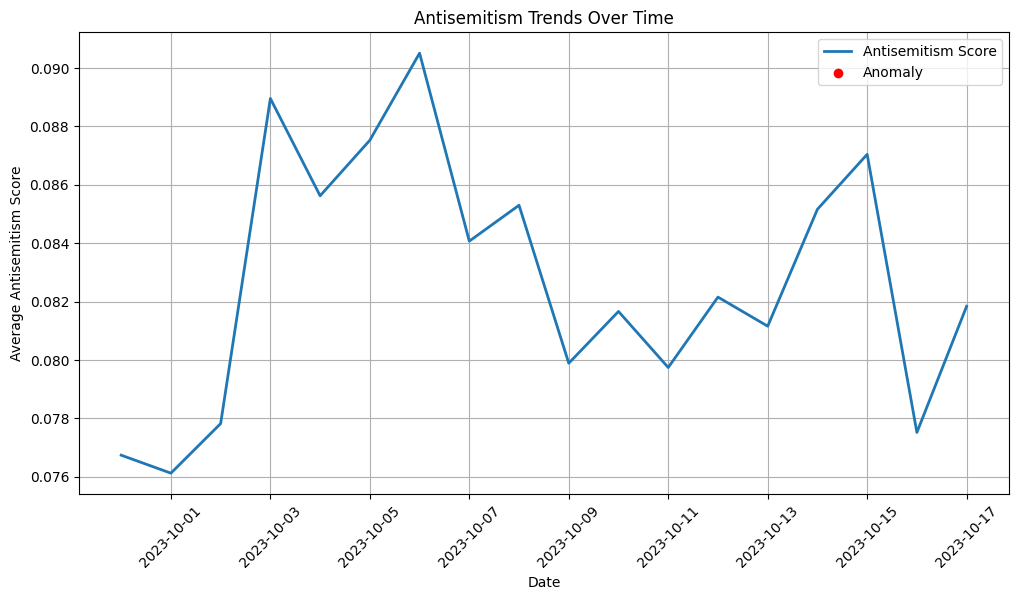

NetworkXError: Node sets of graphs not equal

In [ ]:
import numpy as np
from scipy.stats import zscore

# Aggregate antisemitism scores per day
if 'cardiffnlp/twitter-roberta-base-hate' in post_df.columns and 'Hate-speech-CNERG/dehatebert-mono-english' in post_df.columns:
    post_df['antisemitism_score'] = post_df[['cardiffnlp/twitter-roberta-base-hate', 'Hate-speech-CNERG/dehatebert-mono-english']].mean(axis=1)
    daily_scores = post_df.groupby('date')['antisemitism_score'].mean().reset_index()

    # Compute anomaly detection using Z-score
    daily_scores['z_score'] = zscore(daily_scores['antisemitism_score'])
    daily_scores['anomaly'] = np.abs(daily_scores['z_score']) > 2  # Flag anomalies

    # Plot antisemitism scores over time with anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(daily_scores['date'], daily_scores['antisemitism_score'], label="Antisemitism Score", linewidth=2)
    plt.scatter(daily_scores[daily_scores['anomaly']]['date'], daily_scores[daily_scores['anomaly']]['antisemitism_score'], color='red', label="Anomaly", zorder=3)
    plt.xlabel("Date")
    plt.ylabel("Average Antisemitism Score")
    plt.title("Antisemitism Trends Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()



# Graph Difference Analysis
def compute_graph_difference(daily_graphs):
    graph_diffs = {}
    prev_graph = None

    for date, G in sorted(daily_graphs.items()):
        if prev_graph is not None:
            diff_graph = nx.symmetric_difference(G, prev_graph)  # Find structural changes
            graph_diffs[date] = diff_graph
        prev_graph = G

    return graph_diffs

graph_diffs = compute_graph_difference(daily_graphs)

# Identify key trend changes in the network structure
graph_diff_sizes = {date: len(G.edges()) for date, G in graph_diffs.items()}
diff_trend_df = pd.DataFrame(graph_diff_sizes.items(), columns=["date", "new_edges"])

# Plot network changes over time
plt.figure(figsize=(12, 6))
plt.plot(diff_trend_df["date"], diff_trend_df["new_edges"], marker='o', linestyle='-', label="New Edges in Network")
plt.xlabel("Date")
plt.ylabel("Number of New Edges")
plt.title("Network Structural Changes Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Display graph difference trends


In [ ]:
# savbe all the dfs to drive